In [396]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
from h2o.transforms.decomposition import H2OPCA
h2o.init(max_mem_size="30G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpnma12nei
  JVM stdout: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpnma12nei/h2o_chandlervaughn_started_from_python.out
  JVM stderr: /var/folders/9j/7_jk_t7x19535_plj1rb550m0000gn/T/tmpnma12nei/h2o_chandlervaughn_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,"7 days, 17 hours and 42 minutes"
H2O_cluster_name:,H2O_from_python_chandlervaughn_wbjt4y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,30 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [397]:
#dataset = h2o.import_file('https://song-feature-csvs.s3.amazonaws.com/final_dataset.csv')

ext_drive_dir = '/volumes/CCV_SSD_1/'
dataset = h2o.import_file(ext_drive_dir+'final_dataset_new.csv')
dataset.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(59977, 8090)

In [398]:
# Identify predictors and response
x = dataset.columns
y = "genre"
x.remove(y)

#dataset[y].unique()
dataset[y] = dataset[y].asfactor()

In [399]:
#impute any na's to zero
dataset[x].impute(column = 0, values = [0 for c in range(dataset[x].ncol)])
dataset[x].isna().any()

False

In [400]:
#subset the data so that we can work with it
#eventually we need to do all data for modeling
#using splitframe so we get random rows
subset_dataset_train, subset_dataset_test, therest = dataset.split_frame(ratios=[0.04, 0.04])

In [401]:
print("Rows To Process: " + str(subset_dataset_train.nrows))
print("Dataframe Shape: " + str(subset_dataset_train.shape))

Rows To Process: 2380
Dataframe Shape: (2380, 8090)


In [402]:
#subset the data so that we can work with it
#eventually we need to do all data for modeling
#subset_dataset = dataset[range(0,2000,1),:]
subset_dataset_train[y] = subset_dataset_train[y].asfactor()
subset_dataset_train[x] = subset_dataset_train[x].asnumeric() 
subset_dataset_test[y] = subset_dataset_test[y].asfactor()
subset_dataset_test[x] = subset_dataset_test[x].asnumeric() 

# Setup with the Power pca_method
pca_decomp = H2OPrincipalComponentAnalysisEstimator(k = 150, 
                                                    max_iterations = 1000000 , 
                                                    transform = "Standardize", 
                                                    pca_method="Power",
                                                    use_all_factor_levels=True, 
                                                    impute_missing=True,
                                                    compute_metrics = True)

In [403]:
# Train PCA
pca_decomp.train(x=subset_dataset_train.names, training_frame = subset_dataset_train)

pca Model Build progress: |███████████████████████████████████████████████| 100%


In [404]:
# View the importance of components
var_imp = pca_decomp.varimp(use_pandas=True)
var_imp

,,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150
0,Standard deviation,35.128814,20.110013,18.209408,16.525700,16.045830,14.367111,13.689555,12.943819,12.443022,...,2.481365,2.467354,2.459265,2.442091,2.439666,2.429811,2.412575,2.404962,2.386654,2.366666
1,Proportion of Variance,0.163861,0.053700,0.044029,0.036263,0.034188,0.027409,0.024884,0.022247,0.020559,...,0.000818,0.000808,0.000803,0.000792,0.000790,0.000784,0.000773,0.000768,0.000756,0.000744
2,Cumulative Proportion,0.163861,0.217561,0.261591,0.297854,0.332042,0.359451,0.384335,0.406582,0.427141,...,0.853601,0.854409,0.855212,0.856004,0.856794,0.857578,0.858351,0.859119,0.859876,0.860619


Proportion of Variance Explained "Scree Plot"


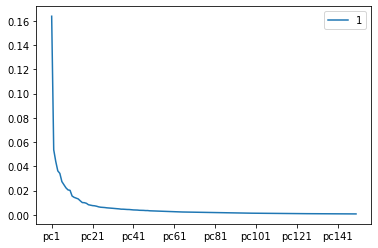

In [405]:
import matplotlib.pyplot as plt
scree = pd.DataFrame(var_imp).T[1]
scree.reset_index()
scree = scree[1:] #take the data less the header row
scree = pd.DataFrame(scree)
print('Proportion of Variance Explained "Scree Plot"')
scree.plot()

Cumulative Proportion of Variance Explained


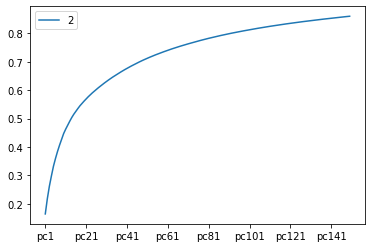

In [406]:
import matplotlib.pyplot as plt
c = pd.DataFrame(var_imp).T[2]
c.reset_index()
c = c[1:] #take the data less the header row
c = pd.DataFrame(c)
print('Cumulative Proportion of Variance Explained')
c.plot()

In [408]:
# View the eigenvectors
pca_decomp.rotation()

# See the whole table with table.as_data_frame()


Rotation: 


,,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150
0,genre.20th Century Classical,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,genre.African,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,genre.Afrobeat,-0.000021,0.000076,0.000017,-0.000014,2.906337e-05,-0.000074,-0.000019,-0.000015,0.000015,...,-5.437302e-05,0.000033,0.000473,-0.000401,-0.000084,0.000283,0.000091,-0.000020,-0.000034,-0.000065
3,genre.Alternative Hip-Hop,0.000002,0.000028,-0.000060,0.000033,-7.066814e-06,0.000008,-0.000015,-0.000021,-0.000042,...,3.171705e-05,0.000006,-0.000061,0.000018,-0.000114,-0.000225,-0.000079,0.000093,0.000208,0.000079
4,genre.Ambient,0.000030,0.000025,0.000209,-0.000048,3.024622e-05,0.000018,0.000010,0.000304,0.000314,...,-7.193372e-04,0.000504,0.001283,0.000361,0.000919,0.000399,0.000859,0.000231,-0.001535,0.000213
5,genre.Ambient Electronic,-0.000010,0.000026,0.000033,-0.000059,-1.251171e-04,-0.000321,-0.000062,0.000013,-0.000045,...,1.848030e-03,-0.003200,-0.001448,0.002163,-0.001296,-0.000537,-0.001742,-0.002081,-0.001105,-0.000778
6,genre.Americana,0.000011,-0.000018,0.000049,-0.000008,-9.934938e-06,0.000011,0.000042,0.000009,-0.000032,...,5.658416e-04,-0.000381,0.000045,0.000339,0.000577,0.000744,-0.000966,-0.000284,-0.000369,-0.000141
7,genre.Asia-Far East,0.000003,-0.000008,0.000032,-0.000009,-5.639965e-07,-0.000002,0.000024,-0.000008,0.000022,...,2.621262e-04,0.000290,-0.000225,-0.000246,-0.000067,-0.000039,0.000101,-0.000132,-0.000161,-0.000051
8,genre.Audio Collage,0.000016,-0.000010,-0.000052,-0.000009,-2.225435e-05,-0.000071,-0.000132,-0.000039,-0.000016,...,3.626232e-06,0.000026,0.000010,0.000238,-0.000810,0.000179,-0.000014,0.000080,-0.000614,-0.000272
9,genre.Avant-Garde,-0.000461,0.000799,-0.000273,-0.000692,3.587731e-04,-0.001732,-0.000112,-0.000976,-0.001020,...,-6.129188e-03,0.004801,-0.004159,-0.001102,0.005659,-0.004071,0.001749,0.001221,-0.001409,0.003471



See the whole table with table.as_data_frame()


In [409]:
subset_dataset_new = pca_decomp.predict(subset_dataset_train)

pca prediction progress: |████████████████████████████████████████████████| 100%


In [410]:
subset_dataset_new

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
-14.3207,35.1366,17.8967,-0.110684,12.2884,-12.9981,3.09233,0.950339,5.44252,-14.3827,-1.91144,-7.50388,6.67861,9.68687,7.09322,-5.29353,10.2902,-3.69246,-6.61193,-1.36193,7.53671,-1.99136,5.22362,-6.01636,3.78931,-7.04107,3.94219,-0.904385,2.76629,0.49666,-0.556727,-8.83384,-7.30431,3.332,11.749,-0.214583,-5.88696,-3.29874,-0.705738,-13.1934,-0.596678,4.75487,-2.76442,6.09423,-0.992762,8.4555,-6.44078,-0.213325,-0.424834,-4.56734,5.47939,0.251117,-3.80295,-5.19204,-5.01615,2.66009,-1.51044,-2.56158,-0.600063,3.36284,8.59136,-0.855689,-1.48577,4.73982,-7.94557,-2.69113,-1.52147,0.913737,5.0986,-1.59049,0.949576,1.24252,-5.53186,-5.83563,-1.30681,-3.75844,-1.88801,-0.92558,2.44292,-2.5219,-1.97778,1.3738,0.320131,2.1243,4.36062,-1.94421,-1.77942,4.93913,-2.14532,6.07703,2.60167,-2.47086,1.34251,7.33726,0.347653,-1.68833,-2.04864,1.29099,0.374482,-0.453922,-1.72163,0.122117,-0.791235,1.6271,2.26906,-1.61671,2.5038,-3.84633,-0.343188,0.871209,-1.42623,1.41752,0.113245,0.365366,-1.82717,0.801268,0.476724,1.78191,0.0307001,0.885677,-0.324455,-0.0380984,1.42932,0.776168,0.417925,1.8219,-0.2285,-1.05785,-2.73198,-1.87878,1.20704,0.0344963,-1.08784,3.66178,1.25612,-1.33477,-1.17885,-0.193228,0.569054,1.01415,3.90669,2.54911,2.37526,-2.73745,-2.65011,-0.437611,-3.71508,-1.68028,1.74354,-1.15251
5.56457,3.94978,-19.921,-3.60842,23.7825,13.6143,-0.457846,0.536523,-5.29624,-6.78605,-8.39236,-6.63896,-5.5749,-9.66934,-6.9275,-2.18792,-4.11102,0.795772,4.97945,3.61684,-2.09484,2.05188,-0.714039,1.99634,2.42435,3.18233,-4.57716,-0.706199,1.04978,-4.0687,1.74367,-5.89381,0.615114,0.252095,-0.605533,0.589263,4.6966,-4.07668,12.3161,6.77647,-5.09428,1.57208,-2.37203,2.14878,3.39161,1.79055,-0.413647,-3.18967,-3.92729,-1.01896,0.197444,-1.62874,0.477053,-1.04523,1.52613,4.33971,1.20506,4.24043,1.86607,2.8716,-2.27987,-0.444949,-2.76665,-1.15549,-2.3959,-1.72505,-0.789122,-1.5892,-2.03309,-1.49458,1.51872,1.18708,-0.469051,-2.82652,0.232284,-1.02164,0.163958,0.659331,3.44498,-2.53232,3.56332,-0.864031,1.38489,1.13511,2.90526,-0.0682963,-8.23546,2.94771,2.86376,2.1372,-0.593822,2.42687,-0.746271,-0.55567,1.42409,-1.40694,0.597099,-0.883656,1.1122,1.76326,-0.788867,-1.33414,-2.39761,1.27923,-4.82222,-4.21049,0.0282853,-0.15411,0.496319,1.76211,0.419455,2.63104,3.46484,-0.651526,-0.957115,-2.02614,-0.497985,0.796062,-1.65783,-0.314548,-1.34605,1.81095,1.89579,-3.3951,0.0799502,-0.681005,1.25375,-2.62247,-0.448926,-1.78048,2.04183,-0.432831,-1.95342,-2.36248,0.359746,2.87566,0.0498317,1.42826,4.30056,-3.35627,2.51444,1.18635,1.18722,1.23108,1.5162,-2.01467,3.14814,-1.96257,-0.474939,2.3795
11.3818,-15.3863,19.0086,-5.34854,-12.6377,-17.3415,-3.6084,-6.95406,2.55538,0.896568,5.27713,-3.1219,3.91191,5.64292,3.52606,-5.982,-1.36271,-4.02483,2.44517,-2.91716,-5.53223,3.4647,-0.185648,4.82719,-5.86192,-0.827177,-0.824981,1.6199,-5.63008,7.74804,5.45173,-1.8178,-3.58579,4.0067,1.82622,4.7231,4.40972,-9.79963,9.12079,-0.917654,-2.41583,1.04396,-6.0083,-7.99676,3.16479,-0.703025,-3.45131,0.846567,2.09632,-0.621754,2.01717,-0.404123,-7.1756,-1.19412,-2.3537,0.502304,-2.22087,4.29398,-1.24239,-2.41186,5.84825,0.800667,4.79826,1.17345,-3.50637,-1.79814,-0.0420873,0.600748,-1.15974,-2.

In [411]:
#append the labels for a new dataset
subset_dataset_new = subset_dataset_new.cbind(subset_dataset_train[y])

In [412]:
train,test,valid = subset_dataset_new.split_frame(ratios=[0.7, 0.15], seed=123)

#reset column names now thats they are new
x = subset_dataset_new.col_names

train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for x base models (limited to 1 hour max runtime by default) max_runtime_secs = 3600
aml = H2OAutoML(max_models=5, balance_classes = True, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |█████████
07:44:23.958: DRF_1_AutoML_20200522_074121 [DRF def_1] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
07:44:24.963: GBM_1_AutoML_20200522_074121 [GBM def_1] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?

█
07:44:25.969: GBM_2_AutoML_20200522_074121 [GBM def_2] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
07:44:26.972: GBM_3_AutoML_20200522_074121 [GBM def_3] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?

█
07:44:27.978: GBM_4_AutoML_20200522_074121 [GBM def_4] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?
07:44:28.981: GBM_5_AutoML_20200522_074121 [GBM def_5] failed: java.lang.IllegalArgumentException: Error during sampling - too few points?

██
07:44:29.989: DeepLearning_1_AutoML_20200522_074121 [DeepLearning def_1] failed: java.lang.IllegalArgumentException: Error durin

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_3_AutoML_20200522_074121,0.712808,3.52247,0.893879,0.79902
XGBoost_1_AutoML_20200522_074121,0.715146,3.40736,0.901006,0.811811
XGBoost_2_AutoML_20200522_074121,0.717876,3.33094,0.90305,0.8155
XGBoost_grid__1_AutoML_20200522_074121_model_1,0.721439,3.33769,0.914118,0.835613
GLM_1_AutoML_20200522_074121,0.730496,3.43465,0.937328,0.878585
StackedEnsemble_BestOfFamily_AutoML_20200522_074121,0.730496,3.43509,0.937061,0.878082
StackedEnsemble_AllModels_AutoML_20200522_074121,0.730496,3.43515,0.937067,0.878095


In [413]:
# Get leaderboard with `extra_columns` = 'ALL'
lb = h2o.automl.get_leaderboard(aml, extra_columns = 'ALL')
lb

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms
XGBoost_3_AutoML_20200522_074121,0.712808,3.52247,0.893879,0.79902,19988,0.027417
XGBoost_1_AutoML_20200522_074121,0.715146,3.40736,0.901006,0.811811,15730,0.023318
XGBoost_2_AutoML_20200522_074121,0.717876,3.33094,0.90305,0.8155,12803,0.023562
XGBoost_grid__1_AutoML_20200522_074121_model_1,0.721439,3.33769,0.914118,0.835613,11205,0.018354
GLM_1_AutoML_20200522_074121,0.730496,3.43465,0.937328,0.878585,78,0.013433
StackedEnsemble_BestOfFamily_AutoML_20200522_074121,0.730496,3.43509,0.937061,0.878082,12995,0.047178
StackedEnsemble_AllModels_AutoML_20200522_074121,0.730496,3.43515,0.937067,0.878095,43312,0.146804


In [414]:
pred = aml.predict(test)
pred.head()

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,20th Century Classical,African,Afrobeat,Alternative Hip-Hop,Ambient,Ambient Electronic,Americana,Asia-Far East,Audio Collage,Avant-Garde,Balkan,Banter,Big Band/Swing,Black-Metal,Bluegrass,Blues,Brazilian,Breakbeat,Breakcore - Hard,British Folk,Celtic,Chamber Music,Chill-out,Chip Music,Chiptune,Choral Music,Christmas,Classical,Comedy,Compilation,Composed Music,Contemporary Classical,Country,Country & Western,Dance,Death-Metal,Disco,Downtempo,Drone,Drum & Bass,Dubstep,Easy Listening,Electro-Punk,Electroacoustic,Electronic,Europe,Experimental,Experimental Pop,Field Recordings,Folk,Freak-Folk,Free-Folk,Free-Jazz,French,Funk,Garage,Glitch,Goth,Grindcore,Hardcore,Hip-Hop,Hip-Hop Beats,Holiday,House,IDM,Improv,Indian,Indie-Rock,Industrial,Instrumental,International,Interview,Jazz,Jazz: Out,Jazz: Vocal,Jungle,Kid-Friendly,Klezmer,Krautrock,Latin,Latin America,Lo-Fi,Loud-Rock,Lounge,Metal,Middle East,Minimal Electronic,Minimalism,Modern Jazz,Musique Concrete,Nerdcore,New Age,New Wave,No Wave,Noise,Noise-Rock,North African,Novelty,Nu-Jazz,Old-Time / Historic,Poetry,Polka,Pop,Post-Punk,Post-Rock,Power-Pop,Progressive,Psych-Folk,Psych-Rock,Punk,Radio,Radio Art,Rap,Reggae - Dub,Rock,Rock Opera,Rockabilly,Romany (Gypsy),Salsa,Shoegaze,Singer-Songwriter,Sludge,Soul-RnB,Sound Art,Sound Collage,Sound Effects,Sound Poetry,Soundtrack,Space-Rock,Spoken,Spoken Weird,Spoken Word,Surf,Synth Pop,Talk Radio,Tango,Techno,Thrash,Trip-Hop,Turkish,Unclassifiable
Electronic,0.000378842,0.000378165,0.00285434,0.00283249,0.00186611,0.0104006,0.00236539,0.00122323,0.00258359,0.064935,0.00309428,0.00154163,0.000378447,0.00097369,0.00150619,0.00743968,0.000376139,0.000376599,0.00531118,0.00151293,0.00106673,0.000376445,0.00103227,0.00621539,0.00547423,0.00121236,0.000376385,0.0100079,0.0003782,0.00211146,0.00146513,0.00251871,0.00424627,0.000377675,0.00116226,0.00145814,0.00234502,0.00456832,0.0028404,0.00259556,0.00152829,0.00156376,0.00817025,0.0034729,0.390332,0.000376701,0.00676228,0.00184018,0.01093,0.00330212,0.00249701,0.00150924,0.000658249,0.000377904,0.00301285,0.00445266,0.00631723,0.00102382,0.00390774,0.00216996,0.00143045,0.0017401,0.000951551,0.00193279,0.00400541,0.0033118,0.000377821,0.00137607,0.00280133,0.00236308,0.00209295,0.000377549,0.0103106,0.00172957,0.000376849,0.00129117,0.00141977,0.000376985,0.00157832,0.000377524,0.00456015,0.00694713,0.003251,0.00163649,0.00144516,0.000378902,0.00117441,0.00226306,0.0010483,0.000377374,0.000378048,0.000376898,0.00597082,0.001978,0.0161508,0.0207143,0.00111647,0.020291,0.000377486,0.00403103,0.000377364,0.00143706,0.00484257,0.0170027,0.00596683,0.0100567,0.00223942,0.00346246,0.0136139,0.00877213,0.000377069,0.00215242,0.00037663,0.00142653,0.0437543,0.000376676,0.000377261,0.00142434,0.000376921,0.000376302,0.00121868,0.00114971,0.00791651,0.000377466,0.0038822,0.000377691,0.0013355,0.0933119,0.00149986,0.00250852,0.00289111,0.000376118,0.000376812,0.000377168,0.000377187,0.000377304,0.00313491,0.000376708,0.00448652,0.000377294,0.00142972
Punk,0.000181339,0.000181014,0.00126194,0.00113307,0.00121533,0.00145443,0.00112705,0.000581576,0.00285266,0.0544621,0.00127191,0.000614233,0.000181149,0.000461723,0.000519505,0.00140832,0.000180045,0.000180265,0.00106256,0.000596222,0.000510608,0.000180191,0.00050047,0.00224544,0.000911916,0.000580317,0.000180163,0.000755228,0.000181031,0.0025686,0.000636511,0.00138365,0.00616141,0.00018078,0.000606415,0.00112671,0.000535549,0.00185982,0.000562036,0.00125282,0.000612902,0.000762359,0.00103719,0.00120748,0.0192257,0.000180314,0.000813484,0.00140022,0.00758734,0.000817738,0.00195991,0.00123788,0.00295711,0.00018089,0.000279002,0.0483028,0.0135575,0.000490065,0.00300886,0.00786433,0.00322781,0.000637196,0.000548159,0.00108313,0.000869383,0.0034833,0.00018085,0.00671777,0.00211429,0.000733173,0.00716138,0.00018072,0.00104875,0.000809234,0.000180385,0.000617729,0.00061687,0.00018045,0.000573629,0.000180708,0.00219213,0.0120745,0.000850999,0.000763335,0.006

In [415]:
perf = aml.leader.model_performance(test)
perf


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.8024049912920768
RMSE: 0.8957706130991777
LogLoss: 3.5691423258093016
Mean Per-Class Error: 0.3959082653138271

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,20th Century Classical,African,Afrobeat,Alternative Hip-Hop,Ambient,Ambient Electronic,Americana,Asia-Far East,Audio Collage,Avant-Garde,...,Synth Pop,Talk Radio,Tango,Techno,Thrash,Trip-Hop,Turkish,Unclassifiable,Error,Rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3 / 3
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,6 / 6
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,2 / 2
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.694444,25 / 36



See the whole table with table.as_data_frame()

Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.239437
1,2,0.312676
2,3,0.380282
3,4,0.464789
4,5,0.507042
5,6,0.535211
6,7,0.554930
7,8,0.574648
8,9,0.594366
9,10,0.616901


In [416]:
perf.auc()

KeyError: 'AUC'

In [395]:
h2o.cluster().shutdown()

H2O session _sid_8aa7 was not closed properly.
